In [1]:
from src import *
from utils import *
import os
import os.path as osp
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from six.moves import cPickle
import torch

In [2]:
config_dict = {
    'gpu': 0, 
    'resume': './logs/first_train',
#     'resume': False,
    
    'max_iteration': 1000000,
    'lr': 0.0001,
    'weight_decay': 0.00001,
    'momentum': 0.99,
    'batch_size': 6,
    'model': 'fcn8',
    'n_class': 30+1,
    'interval_validate': 10000,
}

# log diectory 생성
#here = osp.dirname(osp.abspath(__file__))
here = osp.dirname('./')

now = datetime.datetime.now()
out = osp.join(here, 'logs', 'fcn_'+now.strftime('%m%d_%H%M%S.%f'))

os.makedirs(out)
config_dict['out'] = out # log output directory 넣어줌
args = DictToObject(config_dict)

# GPU선정
os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
cuda = torch.cuda.is_available()


# data loader

In [3]:
label_df = pd.read_csv('./train_answer.csv')


In [4]:
label_df.columns[1:args.n_class]

Index(['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go',
       'happy', 'house', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one',
       'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up',
       'wow', 'yes', 'zero'],
      dtype='object')

In [5]:
# data loader

# 앞에서 9만번까지는 train 그 다음은 valid로 사용
train_dir_list = np.sort(glob.glob('./train/*.wav'))[:90000]
valid_dir_list = np.sort(glob.glob('./train/*.wav'))[90050:90051]

train_dataset = GetTrainDataset(train_dir_list, label_df=label_df.iloc[:90000], class_list=label_df.columns[1:args.n_class]) 
valid_dataset = GetTrainDataset(valid_dir_list, label_df=label_df.iloc[90050:90051], class_list=label_df.columns[1:args.n_class]) 

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0) # 이게 worker 0이어야 에러가안남 broken pipe인지뭔지
valid_loader = DataLoader(dataset=valid_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0) # 이게 worker 0이어야 에러가안남 broken pipe인지뭔지

# model

In [6]:
model = FCN8s(n_class=args.n_class)
start_epoch = 0
start_iteration = 0
if args.resume:
    checkpoint = torch.load(args.resume+'/checkpoint.pth.tar')
    
    # backbone 부분만 불러올려고 쓸모없는 정보는 지워버림
    # class dependancy 있는 친구들 제거
    new_model_dict = model.state_dict()
    pretrained_dict = checkpoint['model_state_dict']
#     pretrained_dict = {k: v for k, v in pretrained_dict.items() if 'block' in k}
    new_model_dict.update(pretrained_dict)
    
    #model.load_state_dict(checkpoint['model_state_dict'])
    model.load_state_dict(new_model_dict)
    start_epoch = checkpoint['epoch']
    start_iteration = checkpoint['iteration']

if cuda:
    model = model.cuda()
    
# optim = torch.optim.SGD(model.parameters(),
# optim = torch.optim.RMSprop(model.parameters(),
#     lr=args.lr,
#     momentum=args.momentum,
#     weight_decay=args.weight_decay)
optim = torch.optim.Adam(model.parameters(),
    lr=args.lr,
    weight_decay=args.weight_decay)
# backbone 로드하는거면 이거 필요없는듯함 
#if args.resume:
#    optim.load_state_dict(checkpoint['optim_state_dict'])


trainer = FCNTrainer(
    cuda=cuda,
    model=model,
    optimizer=optim,
    train_loader=train_loader,
    val_loader=valid_loader,
    out=args.out, # log output director
    max_iter=args.max_iteration,
    n_class=args.n_class,
    interval_validate=args.interval_validate,
)

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


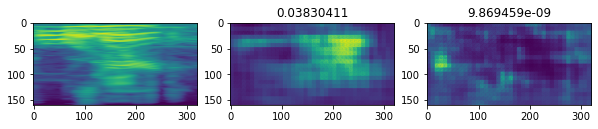

 iteration : 9999, loss :           49570.3672

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


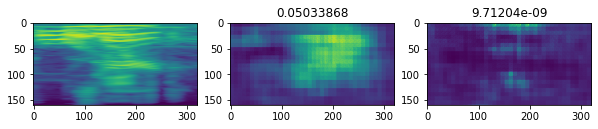

 iteration : 14999, loss :           49673.2031

 iteration : 19999, loss :           51937.9219

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


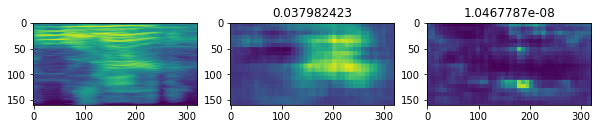

 iteration : 29999, loss :           46620.0469

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


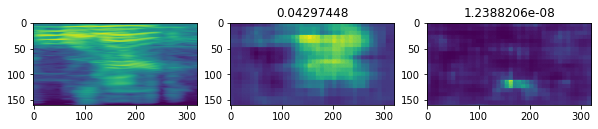

 iteration : 39999, loss :           50712.9375

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


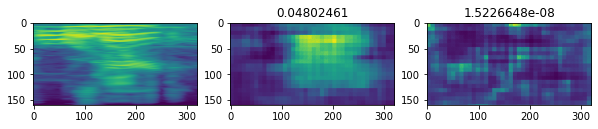

 iteration : 44999, loss :           43717.1953

 iteration : 49999, loss :           50794.1523

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


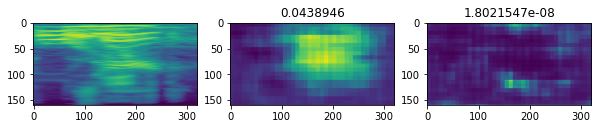

 iteration : 59999, loss :            50066.418

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


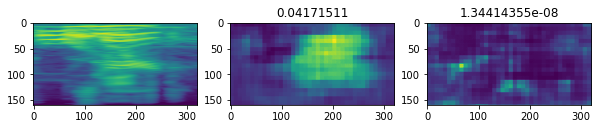

 iteration : 69999, loss :           52781.4375

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


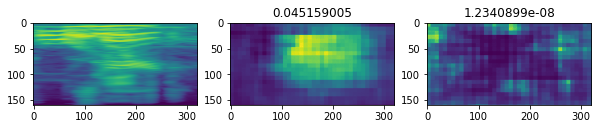

 iteration : 74999, loss :           52893.4492

 iteration : 79999, loss :            54997.543

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


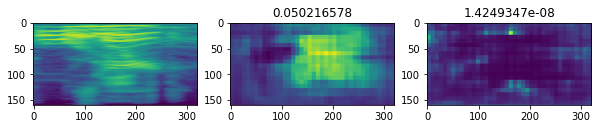

 iteration : 89999, loss :           49463.3945

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


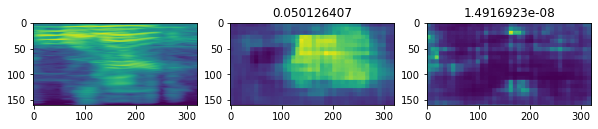

 iteration : 99999, loss :           51214.3438

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


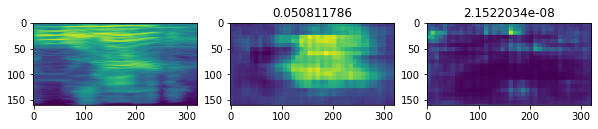

 iteration : 104999, loss :            55200.418

 iteration : 109999, loss :           49413.2031

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


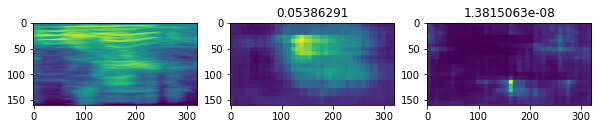

 iteration : 119999, loss :            49174.543

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


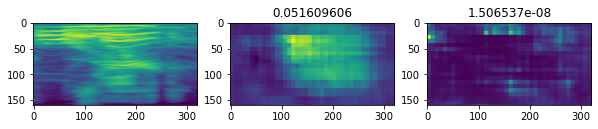

 iteration : 129999, loss :           47707.8672

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


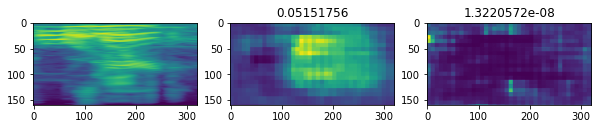

 iteration : 134999, loss :            44048.418

 iteration : 139999, loss :           54040.1211

tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1])


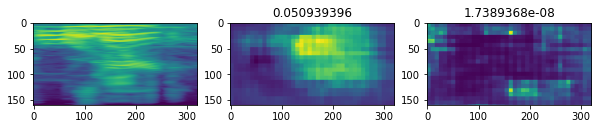

 iteration : 141018, loss :           56448.9414

In [ ]:
# if args.resume:
#     trainer.epoch = checkpoint['iteration']
#     trainer.iteration = checkpoint['epoch']
trainer.train()

In [ ]:
batch_idx, (data, target) = next(enumerate(valid_loader))

val_loss = 0
visualizations = []
label_trues, label_preds = [], []
data, target = data.cuda(), target.cuda()
data, target = Variable(data), Variable(target).to(dtype=torch.long) # target data type 이슈
sys.stdout.write('\r {}'.format(batch_idx))
with torch.no_grad():
    score = model(data)[1]

In [ ]:
for i in range(31):
    if np.array(target[0, i, 0, 0].cpu()) == 1:
        print (i, label_df.columns[1:args.n_class][i-1])
        

In [ ]:
plt.imshow(data[0, 0, :, :].cpu().numpy())
plt.show()

In [ ]:
for i in range(31):
    plt.figure(figsize=(10, 12))
    result = np.array(score[0, i, :, :].cpu())
    plt.title("target label : {} mean {}".format(np.array(target[0, i, 0, 0].cpu()), np.mean(result)))
    plt.imshow(result)
    print (np.mean(result))
    plt.colorbar()
    plt.show()